In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import os
import re
from scipy.interpolate import griddata
from scipy.spatial import Delaunay
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import scipy.spatial.qhull as qhull
import itertools
#from dedalus import public as de

In [2]:
def getproj(z, r_inner, r_outer):    
    if np.abs(z) < r_inner: 
        start_point = np.sqrt(r_inner**2 - z**2)
    else:
        start_point = 0
    end_point = np.sqrt(r_outer**2 - z**2)
    gridpoints = int(rscale.shape[0]/(r_outer-r_inner) * (end_point-start_point))
    
    #finding equidistant point with the same density as the original grid along the path of interpolation
    z_desired = np.asarray(np.linspace( start_point, end_point, num = gridpoints, endpoint = False))
    y_coord = np.asarray([z for _ in z_desired])
    inter_coord = np.asarray([z_desired, y_coord]).T
    if average_z:
        inter_coord = inter_coord[:,::-1]
    #padding and mesh
    phi_pad = np.append(phiscale[:], 2*np.pi)
    s_pad   = np.append(z_desired[:], end_point)
    s_mesh, phi_mesh = np.meshgrid(s_pad, phi_pad)
    
    return inter_coord, s_mesh, phi_mesh

In [36]:
def plotnsave(val, s_mesh, phi_mesh, mydir, y):
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
    pcm = ax.pcolormesh(phi_mesh, s_mesh, val, cmap='RdYlBu_r',vmin = vmin, vmax = vmax)
    ax.set_xticks([])
    ax.set_axis_off()
    ax.set_rlim([0, r_outer])
    cbar_ax = fig.add_axes([0.8, 0.2, 0.02, 0.6])
    cb = fig.colorbar(pcm, cax=cbar_ax)
    #these three line draws the boundaries, because axis_off
    ones = np.ones(300)
    angles = np.linspace(0, 2*np.pi,300)
    style = (0,(4,10))
    if s_mesh[1,0]!= 0:
        ax.fill_between(angles, s_mesh[1,0]*ones, y2 =s_mesh[1,0]*ones, fc='w')
    ax.fill_between(angles, r_inner*ones, y2 =r_inner*ones, fc='none', ec = 'k', linestyle = style)
    ax.fill_between(angles, s_mesh[1,-1]*ones, y2 =s_mesh[1,-1]*ones, fc='none', ec = 'k', linestyle = '-')
    ax.fill_between(angles, r_outer*ones, y2 =r_outer*ones, fc='none', ec = 'k', linestyle = style, linewidth=2.0)
    
    cb.set_label(plotvar, rotation=0)

    plt.savefig(mydir  + '/z%.3f_plot/%s_%04i' %(y ,"plot".format(0), counter) + '_' + plotvar + '.png', dpi=dpi, facecolor ='w')
    plt.close(fig)

In [4]:
#https://stackoverflow.com/questions/20915502/speedup-scipy-griddata-for-multiple-interpolations-between-two-irregular-grids
def interp_weights(xyz, uvw, d=2):
    #xyz is the spherical grid
    #uvw is the desired interpolation grid
    tri = qhull.Delaunay(xyz)
    simplex = tri.find_simplex(uvw)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uvw - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts, fill_value=np.nan):
    ret = np.einsum('nj,nj->n', np.take(values, vtx), wts)
    ret[np.any(wts < 0, axis=1)] = fill_value
    return ret

In [5]:
def get_file_name(mydir):
    files = []
    for file in os.listdir(mydir):
        if file.endswith(".h5"):
            files.append(os.path.join(mydir, file))
    files.sort(key=lambda f: int(re.sub('\D','', f)))
    
    files = files[head:-2]
    
    return files

In [31]:
#    if data.ndim == 5: np.linalg.norm(data, axis=4)
#NEW!
def new_makeplots(mydir, r_inner, r_outer, y):
    #maybe not the best way, but I got lazy, and didn't want to not wrap everything in a function
    global files, data, rscale, thetascale, phiscale, counter, s_mesh, phi_mesh, vtx, wts

    files = get_file_name(mydir)
    
    counter = 0
    zdata = []
    
    for file in files:
        df = h5py.File(file,"r")
        
        dname = 'tasks/' + plotvar
        dataset = df[dname]
        data = np.array(dataset)
        if data.ndim == 5:
            data = data[:,0,:,:,:]
        
        if counter == 0:
            
            rscale = dataset.dims[3][0][:]
            thetascale = dataset.dims[2][0][:]
            phiscale = dataset.dims[1][0][:]

            inter_coord, s_mesh, phi_mesh = getproj(y, r_inner, r_outer)

            xygrid = np.asarray([[r*np.sin(theta), r*np.cos(theta)] for theta in thetascale for r in rscale])
            
            vtx, wts = interp_weights(xygrid, inter_coord)
            
            plot_dir = mydir + '/z%.3f_plot' %(y)
            if not os.path.exists(plot_dir):
                os.makedirs(plot_dir)
        
        for dats in data:
            grid_z0 = np.asarray([interpolate(np.ravel(dat), vtx, wts) for dat in dats])
            
            if saveplots:
                plotnsave(grid_z0, s_mesh, phi_mesh, mydir, y)
                
            if getData:
                zdata.append(grid_z0)
                
            counter += 1
            
    if getData:
        return zdata

In [13]:
mydir = "data_Ek5e-6Ra300_L191N63_init5max10e-7-u"
r_inner = 7/13.
r_outer = 20./13.
plotvar = 'u'
remove_m0 = False
saveplots = True
dpi = 300
getData = False
cutheadtail = False
method = 'fastlinear'
vmin = -250 
vmax = 250
z = r_inner
%time makeplots(mydir, r_inner, r_outer, z)

CPU times: user 7min 15s, sys: 45.3 s, total: 8min
Wall time: 7min 59s


In [37]:
mydir = "data_Ek5e-6Ra300_L191N63_init5max10e-7-u"
r_inner = 7/13.
r_outer = 20./13.
plotvar = 'u'
remove_m0 = False
saveplots = True
dpi = 300
getData = True
head = 5
vmin = -250 
vmax = 250
z = r_inner
average_z = False
%time result2 = new_makeplots(mydir, r_inner, r_outer, z)

CPU times: user 5min 42s, sys: 1min 13s, total: 6min 55s
Wall time: 6min 54s


In [35]:
result2=np.array(result2)
result2.shape

(340, 384, 92)

In [42]:
overbar = np.mean(result2, axis = 1)

In [57]:
fluctuating = result2 - np.mean(result2, axis = 1, keepdims=True)

In [59]:
fluctuating.shape

(340, 384, 92)

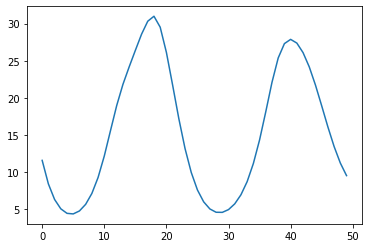

In [61]:
plt.plot(overbar[100:150,34])

In [50]:
s_mesh[0,34]

0.5326001637430072

In [21]:
%time data = np.asarray(dataset)

CPU times: user 8.16 s, sys: 1.25 s, total: 9.41 s
Wall time: 9.31 s


In [19]:
%time data = data[:,0,:,:,:]

CPU times: user 22 µs, sys: 4 µs, total: 26 µs
Wall time: 32.4 µs


In [101]:
result2[0,0]-test

array([            nan, -6.48864386e-05, -7.37916565e-05, -1.27107630e-04,
       -7.20284866e-04, -2.21939988e-03, -5.12323237e-03, -5.16918472e-03,
       -8.34778554e-03, -9.68516664e-03, -1.33645665e-02, -1.02446806e-02,
        3.50217977e-03,  3.07211175e-02,  1.34347758e-01,  5.13880557e-02,
       -1.11581354e-01,  2.60417574e-01,  2.63643449e-01,  3.76708501e-01,
        4.93814785e-01,  4.40649142e-01,  4.20759299e-01,  6.90793767e-02,
       -7.28855286e-01, -1.76792262e+00, -2.98671475e+00, -3.87920311e+00,
       -3.78263937e+00, -2.03455670e+00,  6.07378170e-01,  3.86963555e+00,
        4.75641092e+00,  4.48324297e-01, -1.43507261e+01, -1.78229049e+01,
        1.26670794e+01,  6.03513676e+01,  1.03838017e+02,  1.37658743e+02,
        1.58488557e+02,  1.67726350e+02,  1.55229275e+02,  1.34296323e+02,
        1.00445355e+02,  6.33867374e+01,  2.71022616e+01, -5.18711252e+00,
       -3.00514420e+01, -4.95149839e+01, -6.33689159e+01, -7.20204447e+01,
       -7.79076219e+01, -

In [97]:
result.shape

(20, 384, 92)

In [126]:
result = np.asarray(result)
result2 = np.asarray(result2)

In [31]:
result[0,0]

array([            nan,  1.75305072e-03,  1.23849628e-02,  3.13311380e-02,
        6.10813204e-02,  7.89918635e-02,  9.52896813e-02,  1.07642654e-01,
        1.22897404e-01,  1.40587375e-01,  1.58507434e-01,  1.78014650e-01,
        1.59038112e-01,  2.22636090e-01,  5.11983377e-01,  2.62897438e-01,
        2.33450994e-01,  2.50398657e-01,  2.54750133e-01,  4.14385096e-01,
        2.86142383e-01,  1.74151549e-01,  1.53324740e-01,  7.75412579e-02,
        4.54657697e-02,  7.96444441e-02,  1.73035390e-01,  2.72724932e-01,
        3.25913767e-01,  4.41477598e-01,  8.55486334e-01,  1.71925270e+00,
        8.57766103e+00,  2.48780539e+01,  6.43987325e+01,  1.06808317e+02,
        1.26469568e+02,  1.31022571e+02,  1.19707165e+02,  1.04201369e+02,
        7.82649175e+01,  4.66144478e+01,  1.07623721e+01, -2.44590058e+01,
       -5.68215043e+01, -8.37201769e+01, -1.00445419e+02, -1.09199719e+02,
       -1.06996107e+02, -9.47629200e+01, -7.68650100e+01, -5.49779746e+01,
       -3.27726430e+01, -

In [32]:
result2[0,0]

array([            nan,  1.64817315e-03,  1.15797843e-02,  3.24834318e-02,
        6.09009103e-02,  7.89918635e-02,  9.53754838e-02,  1.07520488e-01,
        1.22897404e-01,  1.40587375e-01,  1.58139589e-01,  1.74844718e-01,
        1.59038112e-01,  2.22636090e-01,  5.11983377e-01,  2.07742712e-01,
        2.24049184e-01,  2.89185348e-01,  2.36153677e-01,  4.16562958e-01,
        2.60061233e-01,  1.80695702e-01,  1.53324740e-01,  7.12619085e-02,
        4.93206420e-02,  7.96444441e-02,  1.71079831e-01,  2.71467094e-01,
        3.22486012e-01,  4.68535375e-01,  8.55486334e-01,  1.98085252e+00,
        8.57766103e+00,  2.48780539e+01,  6.45899345e+01,  1.07164482e+02,
        1.29012804e+02,  1.30677567e+02,  1.21622651e+02,  1.04353287e+02,
        7.82649175e+01,  4.67853440e+01,  1.06550898e+01, -2.44590058e+01,
       -5.68215043e+01, -8.37201769e+01, -1.00445419e+02, -1.09199719e+02,
       -1.05853122e+02, -9.47020228e+01, -7.64675959e+01, -5.49779746e+01,
       -3.27726430e+01, -

In [54]:
mydir = "data_Ek5e-6Ra300_L191N63_init5max10e-7-u"
r_inner = 7/13.
r_outer = 20./13.
zs = np.linspace(-r_outer, r_outer, 66)[1:-1]
#zs = np.geomspace((r_outer+1)**2,1, 31)**(1/2)-1 not complete thought
plotvar = 'u'
remove_m0 = False
saveplots = False
getData = True
cutheadtail = True
method = 'fastlinear'
#vmin = -300 
#vmax = 300
alldata =[]
for z in zs:
    alldata.append(makeplots(mydir, r_inner, r_outer, z))

In [56]:
tempvar = [np.asarray(data) for data in alldata]

In [162]:
tempvar[0][0,0,1] == np.nan

False

In [163]:
np.mean([2,4,np.nan,np.nan])

nan

In [6]:
test= np.random.rand(5,2)
test

array([[0.88844704, 0.35048724],
       [0.43160223, 0.63876201],
       [0.66744567, 0.95312067],
       [0.94556566, 0.12424923],
       [0.54272471, 0.01398695]])

In [11]:
test = test[:,::-1]
test

array([[0.88844704, 0.35048724],
       [0.43160223, 0.63876201],
       [0.66744567, 0.95312067],
       [0.94556566, 0.12424923],
       [0.54272471, 0.01398695]])

In [62]:
[print(var.shape[2]) for var in tempvar]

24
34
41
47
52
57
61
64
68
71
73
76
78
80
82
84
86
88
89
90
92
79
75
72
69
68
66
65
65
64
64
64
64
64
64
65
65
66
68
69
72
75
79
92
90
89
88
86
84
82
80
78
76
73
71
68
64
61
57
52
47
41
34
24


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

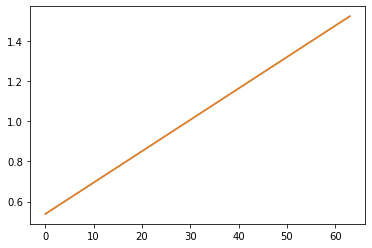

In [104]:
    z = 0
    if np.abs(z) < r_inner: 
        start_point = np.sqrt(r_inner**2 - z**2)
    else:
        start_point = np.arange(r_inner+density, 0, -density)[-1]
    end_point = np.sqrt(r_outer**2 - z**2)
    density = (r_outer-r_inner)/rscale.shape[0]
    gridpoints = int(rscale.shape[0]/(r_outer-r_inner) * (end_point-start_point))
    #finding equidistant point with the same density as the original grid along the path of interpolation
    z_desired = np.asarray(np.linspace( start_point, end_point, num = gridpoints, endpoint = False))
    z_desired2 = np.arange(start_point, end_point, density)
    plt.plot(z_desired)
    plt.plot(z_desired2)

In [145]:
    rthetaphi = np.asarray([[r, theta, phi] for phi in phiscale for theta in thetascale for r in rscale])

In [183]:
    gridpoints = int(rscale.shape[0]/(r_outer-r_inner) * 2*r_outer)
    #finding equidistant point with the same density as the original grid along the path of interpolation
    z_pad = np.append(np.asarray(np.linspace( -r_outer, r_outer, num = gridpoints, endpoint = False)),r_outer)
    z_desired = z_pad[1:-1]
    
    gridpoints = int(rscale.shape[0]/(r_outer-r_inner) * r_outer)
    r_pad = np.append(np.asarray(np.linspace( 0, r_outer, num = gridpoints, endpoint = False)),r_outer)
    r_desired = r_pad[:-1]

In [186]:
    rthetaphi_desired = np.asarray([[np.sqrt(r**2+z**2), np.arccos(z/np.sqrt(r**2+z**2)), phi] for phi in phiscale for z in z_desired for r in r_desired])

In [ ]:
%time answer = griddata(rthetaphi, data[0].ravel(), rthetaphi_desired)

In [ ]:
answer.shape

In [200]:
rthetaphi.shape

(4718592, 3)

In [98]:
    start_point = np.arange(r_inner+density, 0, -density)[-1]
    np.arange(start_point, end_point, density)

array([0.00721154, 0.02283654, 0.03846154, 0.05408654, 0.06971154,
       0.08533654, 0.10096154, 0.11658654, 0.13221154, 0.14783654,
       0.16346154, 0.17908654, 0.19471154, 0.21033654, 0.22596154,
       0.24158654, 0.25721154, 0.27283654, 0.28846154, 0.30408654,
       0.31971154, 0.33533654, 0.35096154, 0.36658654, 0.38221154,
       0.39783654, 0.41346154, 0.42908654, 0.44471154, 0.46033654,
       0.47596154, 0.49158654, 0.50721154, 0.52283654, 0.53846154,
       0.55408654, 0.56971154, 0.58533654, 0.60096154, 0.61658654,
       0.63221154, 0.64783654, 0.66346154, 0.67908654, 0.69471154,
       0.71033654, 0.72596154, 0.74158654, 0.75721154, 0.77283654,
       0.78846154, 0.80408654, 0.81971154, 0.83533654, 0.85096154,
       0.86658654, 0.88221154, 0.89783654, 0.91346154, 0.92908654,
       0.94471154, 0.96033654, 0.97596154, 0.99158654, 1.00721154,
       1.02283654, 1.03846154, 1.05408654, 1.06971154, 1.08533654,
       1.10096154, 1.11658654, 1.13221154, 1.14783654, 1.16346

In [126]:
density = 3*(r_outer-r_inner)/rscale.shape[0]

In [127]:
zs = [np.sqrt(2*n*r_inner*density - n**2*density**2) for n in range(len(np.arange(r_inner, 0, -density)))]
zs

[0.0,
 0.219735075956865,
 0.3035992028341617,
 0.3628593626562607,
 0.40837094279965236,
 0.44437844854228264,
 0.47305713490509305,
 0.49568071274801945,
 0.5130508296905423,
 0.525688508008234,
 0.5339298922215278,
 0.5379770635570456]

In [144]:
data.shape

(10, 384, 192, 64)

In [143]:
np.mean(tempvar[0], axis =1, keepdims = True).shape

(340, 1, 24)

In [128]:
np.sqrt(r_inner**2*np.ones(len(zs)) - np.array(zs)**2)

array([0.53846154, 0.49158654, 0.44471154, 0.39783654, 0.35096154,
       0.30408654, 0.25721154, 0.21033654, 0.16346154, 0.11658654,
       0.06971154, 0.02283654])

In [130]:
    np.arange(r_inner, 0, -4*density)

array([0.53846154, 0.35096154, 0.16346154])

In [69]:
mydir = "data_Ek5e-6Ra300_L191N63_init5max10e-7-u"
r_inner = 7/13.
r_outer = 20./13.
#z = r_inner + factor*(r_outer-r_inner)
z = 0
plotvar = 'T'
remove_m0 = False
saveplots = False
getData = True
cutheadtail = True
alldata = []
vmin = -0.1
vmax = 0.1
method = 'fastlinear'
%time makeplots(mydir, r_inner, r_outer, z)

CPU times: user 1min 25s, sys: 13.6 s, total: 1min 38s
Wall time: 1min 38s


In [63]:
mydir = "data_Ek5e-6Ra300_L191N63_init5max10e-7-u"
r_inner = 7/13.
r_outer = 20./13.
#z = r_inner + factor*(r_outer-r_inner)
z = 0
plotvar = 'T'
remove_m0 = False
saveplots = False
getData = True
cutheadtail = True
alldata = []
vmin = 0
vmax = 1
method = 'fastlinear'
%time makeplots(mydir, r_inner, r_outer, z)

CPU times: user 2min 46s, sys: 15.8 s, total: 3min 2s
Wall time: 3min 1s
